In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

print("Import done!")

Global seed set to 0


Import done!


In [3]:
#Load adata_vis file from previous run....
#adata_vis = sc.read_h5ad('./hamstring_aug2022_results/2cellsperspot_10alpha/sp.h5ad')
#adata_vis

AnnData object with n_obs × n_vars = 2981 × 13167
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene', '_indices', '_scvi_batch', '_scvi_labels', 'TNNT3+ TRDN+ cells', 'FBLN+ Fibroblasts', 'TNNT1+ TRDN+ cells', 'MKX+ Fibroblasts', 'COL22A1+ TRDN+ cells', 'Vascular endothelium', 'Satellite cells', 'Mural cells', 'Lymphatic endothelium', 'Smooth Muscle Cells', 'Adipocytes', 'Immune cells'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_s

In [2]:
#loading visium data
adata_vis = sc.read_visium("./Ham1/", count_file='filtered_feature_bc_matrix.h5')
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
adata_vis.var
adata_vis

/home/l/lramosmu/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2981 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

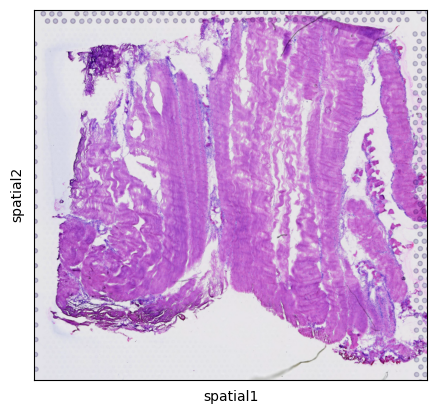

In [3]:
sc.pl.spatial(adata=adata_vis)

In [4]:
adata_vis.obs

,in_tissue,array_row,array_col,sample
AAACAAGTATCTCCCA-1,1,50,102,Ham1
AAACACCAATAACTGC-1,1,59,19,Ham1
AAACAGAGCGACTCCT-1,1,14,94,Ham1
AAACAGCTTTCAGAAG-1,1,43,9,Ham1
AAACAGGGTCTATATT-1,1,47,13,Ham1
...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,Ham1
TTGTTGTGTGTCAAGA-1,1,31,77,Ham1
TTGTTTCACATCCAGG-1,1,58,42,Ham1
TTGTTTCATTAGTCTA-1,1,60,30,Ham1


In [6]:
# find mitochondria-encoded (MT) genes
adata_vis.var['mt'] = adata_vis.var_names.str.startswith("MT-")
# ribosomal genes
adata_vis.var['ribo'] = adata_vis.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata_vis.var['hb'] = adata_vis.var_names.str.contains(("^HB[^(P)]"))

In [7]:
adata_vis.var

,gene_ids,feature_types,genome,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False
...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,False,False,False
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,False,False,False
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,False,False,False
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,False,False


In [8]:
sc.pp.calculate_qc_metrics(adata_vis, qc_vars=["mt"], inplace=True)
adata_vis.obs

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACAAGTATCTCCCA-1,1,50,102,Ham1,163,5.099866,226.0,5.424950,50.000000,72.123894,100.000000,100.0,21.0,3.091043,9.292035
AAACACCAATAACTGC-1,1,59,19,Ham1,284,5.652489,491.0,6.198479,46.435845,62.525458,82.892057,100.0,83.0,4.430817,16.904276
AAACAGAGCGACTCCT-1,1,14,94,Ham1,139,4.941642,188.0,5.241747,52.659574,79.255319,100.000000,100.0,25.0,3.258096,13.297873
AAACAGCTTTCAGAAG-1,1,43,9,Ham1,102,4.634729,121.0,4.804021,57.024793,98.347107,100.000000,100.0,19.0,2.995732,15.702480
AAACAGGGTCTATATT-1,1,47,13,Ham1,70,4.262680,95.0,4.564348,78.947368,100.000000,100.000000,100.0,20.0,3.044523,21.052631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,Ham1,66,4.204693,86.0,4.465908,81.395349,100.000000,100.000000,100.0,19.0,2.995732,22.093023
TTGTTGTGTGTCAAGA-1,1,31,77,Ham1,97,4.584967,121.0,4.804021,61.157025,100.000000,100.000000,100.0,24.0,3.218876,19.834711
TTGTTTCACATCCAGG-1,1,58,42,Ham1,80,4.394449,140.0,4.948760,78.571429,100.000000,100.000000,100.0,60.0,4.110874,42.857143
TTGTTTCATTAGTCTA-1,1,60,30,Ham1,206,5.332719,274.0,5.616771,43.065693,61.313869,97.810219,100.0,43.0,3.784190,15.693431


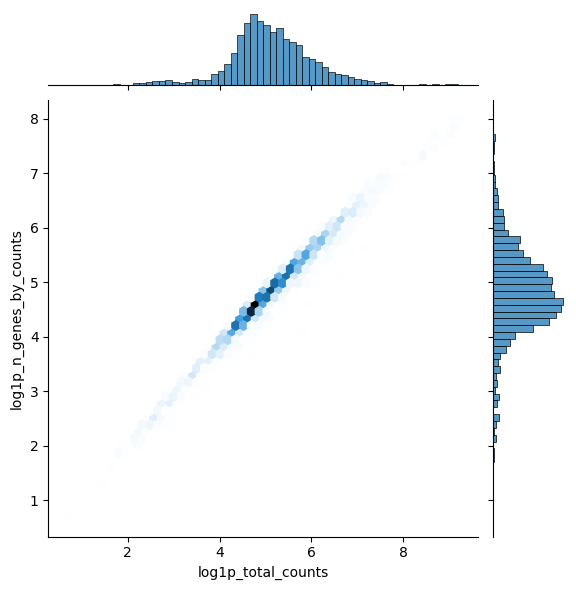

In [9]:
sns.jointplot(
    data=adata_vis.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

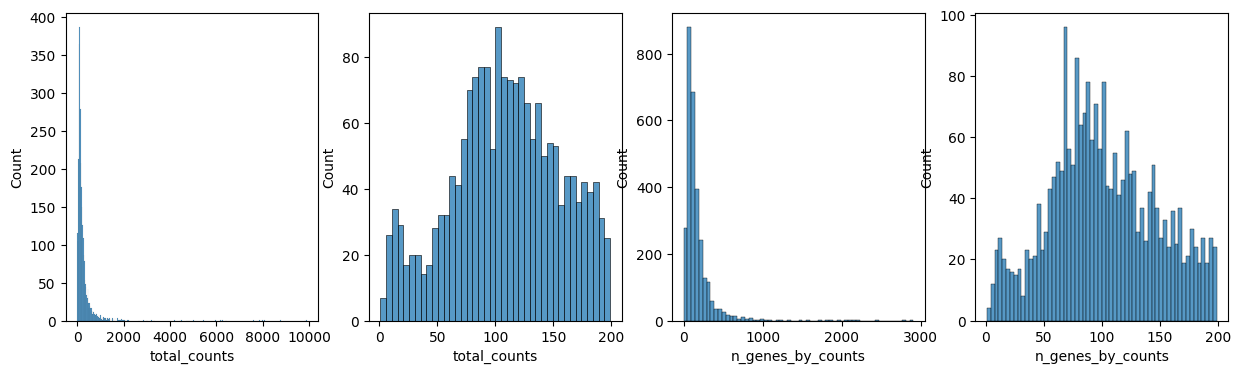

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata_vis.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata_vis.obs["total_counts"][adata_vis.obs["total_counts"] < 200], kde=False, bins=40, ax=axs[1])
sns.histplot(adata_vis.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata_vis.obs["n_genes_by_counts"][adata_vis.obs["n_genes_by_counts"] < 200], kde=False, bins=60, ax=axs[3])

In [205]:
adata_vis = adata_vis_orig
adata_vis_orig

AnnData object with n_obs × n_vars = 2818 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [206]:
sc.pp.filter_cells(adata_vis, min_counts=40)
#sc.pp.filter_cells(adata, max_counts=35000)
adata_vis = adata_vis[adata_vis.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata_vis.n_obs}")
sc.pp.filter_genes(adata_vis, min_cells=2)

#cells after MT filter: 2327


/home/l/lramosmu/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/l/lramosmu/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/l/lramosmu/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


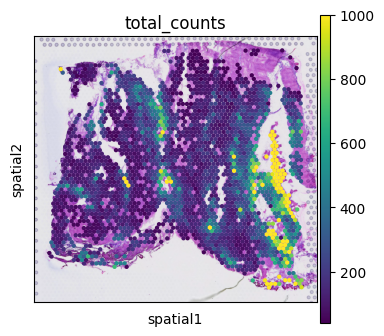

In [207]:
sc.pl.spatial(adata_vis, img_key="hires", color='total_counts', spot_size=40, vmax=1000)

In [208]:
sc.pp.normalize_total(adata_vis, inplace=True)
sc.pp.log1p(adata_vis)
sc.pp.highly_variable_genes(adata_vis, flavor="seurat", n_top_genes=2000) #1000 genes, before it was 2000

In [209]:
adata_vis
#highly variable, means and dispersions, and dispersions norm have been adedd

AnnData object with n_obs × n_vars = 2327 × 12921
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

In [210]:
sc.pp.pca(adata_vis)
sc.pp.neighbors(adata_vis)
sc.tl.umap(adata_vis)
adata_vis

AnnData object with n_obs × n_vars = 2327 × 12921
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [226]:
sc.tl.leiden(adata_vis, resolution=0.7, key_added="clusters")

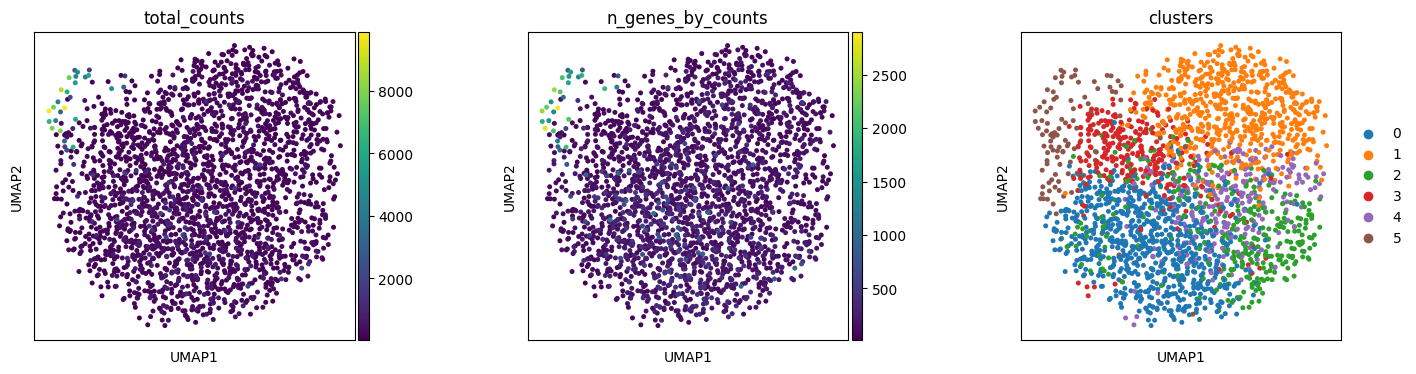

In [227]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_vis, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

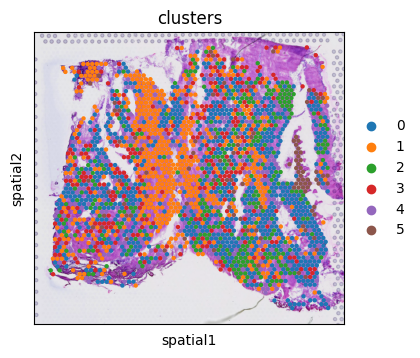

In [228]:
sc.pl.spatial(adata_vis, img_key="hires", color="clusters", size=1.5)

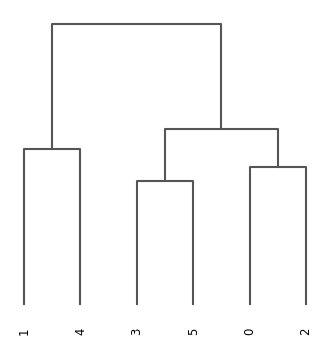

<AxesSubplot:>

In [229]:
sc.tl.dendrogram(adata_vis, groupby='clusters')
sc.pl.dendrogram(adata_vis, groupby='clusters')

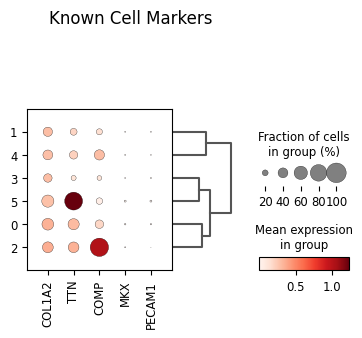

In [230]:
markers = ['COL1A2', 'TTN', 'COMP', 'MKX', 'PECAM1']
sc.pl.dotplot(adata_vis, markers, groupby='clusters', dendrogram=True, title="Known Cell Markers")

/home/l/lramosmu/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


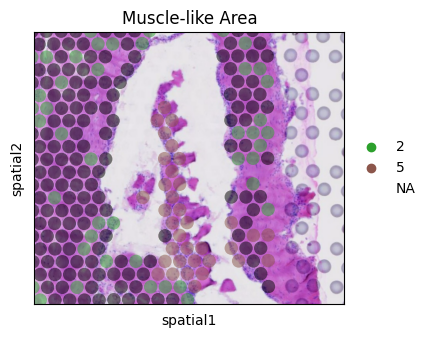

In [231]:
#code to crop part of the image. Our hires image is 2000x2000 pixels. Top left is 0,0.
#Coordinates to use for cropping the image (left, right, top, bottom)
sc.pl.spatial(adata_vis, img_key="hires", color="clusters", groups=["2", "5"], crop_coord=[2200, 3000, 900, 1600], alpha=0.5, size=1.4, title="Muscle-like Area")

categories: 0, 1, 2, etc.
var_group_labels: 5


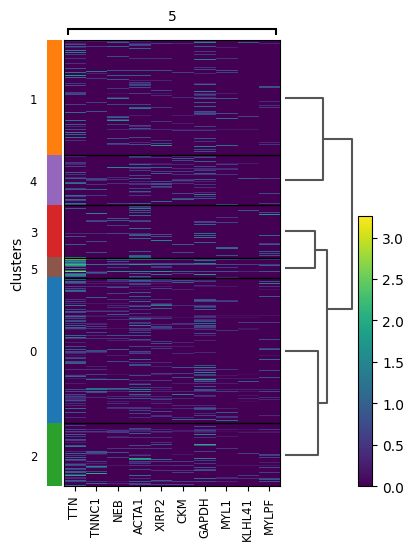

categories: 0, 1, 2, etc.
var_group_labels: 4


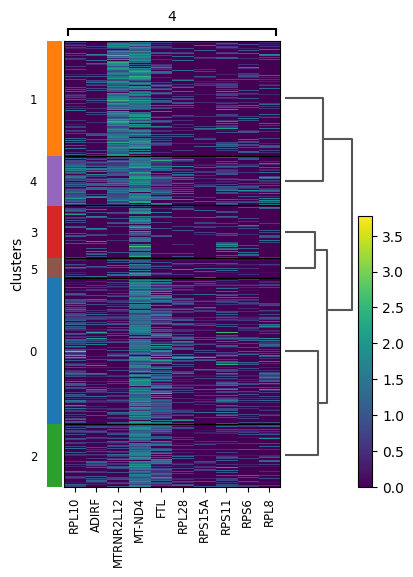

categories: 0, 1, 2, etc.
var_group_labels: 3


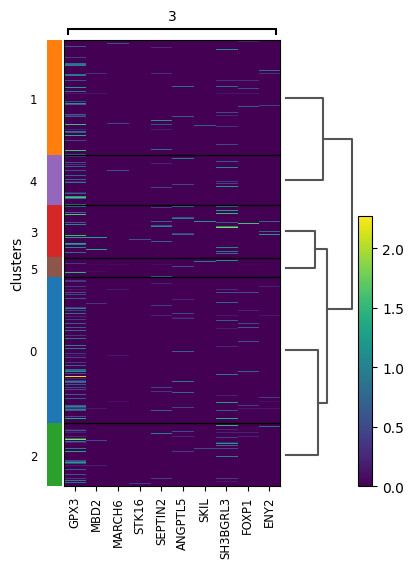

categories: 0, 1, 2, etc.
var_group_labels: 2


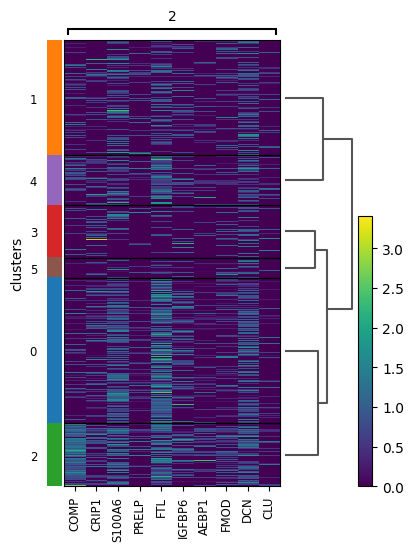

categories: 0, 1, 2, etc.
var_group_labels: 1


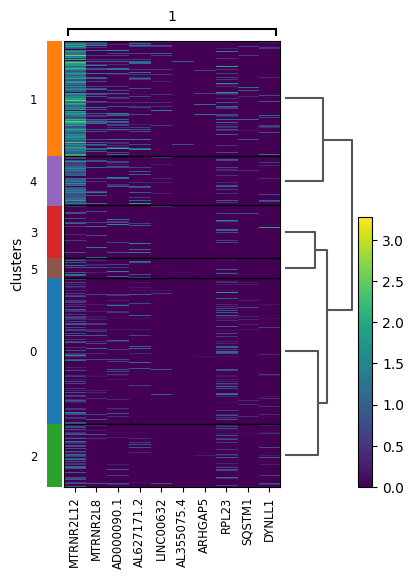

categories: 0, 1, 2, etc.
var_group_labels: 0


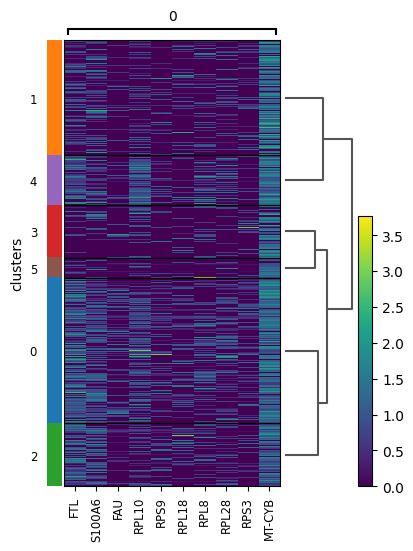

In [232]:
sc.tl.rank_genes_groups(adata_vis, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata_vis, groups="5", n_genes=10, groupby="clusters")
sc.pl.rank_genes_groups_heatmap(adata_vis, groups="4", n_genes=10, groupby="clusters")
sc.pl.rank_genes_groups_heatmap(adata_vis, groups="3", n_genes=10, groupby="clusters")
sc.pl.rank_genes_groups_heatmap(adata_vis, groups="2", n_genes=10, groupby="clusters")
sc.pl.rank_genes_groups_heatmap(adata_vis, groups="1", n_genes=10, groupby="clusters")
sc.pl.rank_genes_groups_heatmap(adata_vis, groups="0", n_genes=10, groupby="clusters")

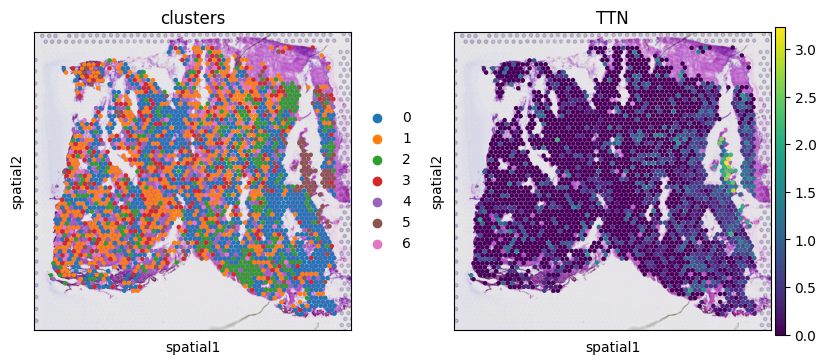

In [185]:
sc.pl.spatial(adata_vis, img_key="hires", color=["clusters", "TTN"], size=1.5)

/home/l/lramosmu/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


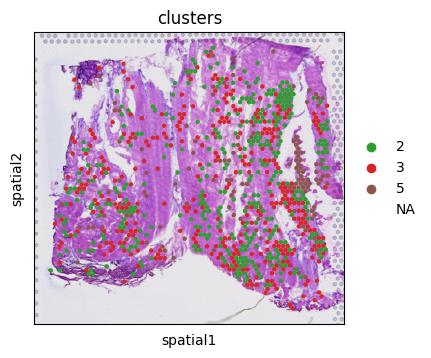

In [218]:
sc.pl.spatial(adata_vis, img_key="hires", color="clusters", groups=["3", "2", "5"], size=1.5)

In [ ]:
lib_a = "Hamstring_Middle"

adata_middle_subset = adata_vis[
    (adata_vis.obs.library_id == lib_a) 
    & (counts_adata.obsm["spatial"][:, 1] < 6000), :
].copy()

